In [1]:
#using TaylorSeries
include("UndrivenHelium.jl")
#include("Integ.jl")
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false, size=(600,600), color=:black, markersize = 0.3 )
const Z = 2.0
const order = 34
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000;

## Revisamos compatibilidad hamiltoniano vs ecs de movimiento

  2.754705 seconds (1.45 M allocations: 77.488 MiB, 5.95% gc time)



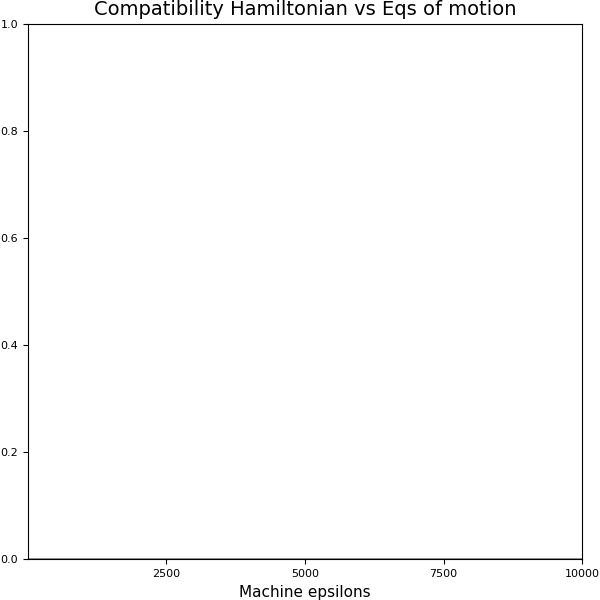

In [2]:
@time dnorm= errHam2D(10_000);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")
xaxis!("Machine epsilons")

# Incluimos funciones para obtener secciones de Poincaré

In [3]:
include("Integ.jl")

taylorintegps (generic function with 1 method)

In [4]:
c1 = condini2D(5.0, 0.0, 0.0, 0.0, 0.0)

8-element Array{Float64,1}:
 2.23607
 0.0    
 0.0    
 0.0    
 0.0    
 0.0    
 4.0    
 0.0    

In [ ]:
t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

In [ ]:
t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=100)
@time t2, x2 = taylorintegps(undrivenHelium1D!, c1, t0, 120.0, order, abs_tol, maxsteps=10_000);

In [ ]:
length(t1), length(t2)

In [ ]:
ene1 = zeros(t1)
ene2 = zeros(t2)
for j in eachindex(ene1)
    ene1[j] = abs(regHam1D(x1[j,:]))/eps()
end
for j in eachindex(ene2)
    ene2[j] = abs(regHam1D(x2[j,:]))/eps()
end

In [ ]:
plot(t1, ene1, title =L"Absolute Error of Energy $q_1=2$", color = :black)
plot!(t2, ene2, title =L"Absolute Error of Energy $q_1=2$",color=:red, label=L"Cálculo con Sección de Poincaré")
xaxis!(L"t")
yaxis!(L"\delta E")


In [ ]:
plot(t2, ene2, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [ ]:
maximum(ene1)

# Implementamos funciones para obtener gráficas de las secciones de Poincaré

In [ ]:
function psundriven{T<:Number}(x10::T, px10::T; tol::Float64 = 1e-20, tmax = 100.0, maxsteps1 = 5_000 )
    c1 = condini1D(x10, px10)
    t, x, tp, xp = taylorintegps(undrivenHelium1D!, c1, t0, tmax, order, abs_tol; maxsteps = maxsteps1)
    
    xpm = similar(xp)
    xpm[:,1] = map(ks, xp[:,1])
    xpm[:,3] = Float64[ksv(xp[k,1], xp[k, 3]) for k in eachindex(tp)]
    xpm[:,2] = map(ks, xp[:,2])
    xpm[:,4] = Float64[ksv(xp[k,2], xp[k, 4]) for k in eachindex(tp)]

    return xpm, t, x
end

In [ ]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreps(n::Int) = Symbol( string("ps", n) )
nombreq(n::Int) = Symbol( string("q", n) )
nombrexs(n::Int) = Symbol( string("xs", n) )
nombrevxs(n::Int) = Symbol( string("vxs", n) )
nombreys(n::Int) = Symbol( string("ys", n) )
nombrevys(n::Int) = Symbol( string("vys", n) )

function orbits(nmin, rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = nmin:(N+nmin - 1)
        ex1 = quote 
            $(nombreps(j)), $(nombret(j)), $(nombreq(j))  = 
                psundriven(Float64($(rs[j])), 0.0; tmax = 100.0, maxsteps1 = 5_000 )
             end
        ex2 = quote 
                $(nombrexs(j)) = $(nombreps(j))[:,1]
             end
        
        ex3 = quote 
                 $(nombrevxs(j)) =  $(nombreps(j))[:,3]
             end
        ex4 = quote 
                $(nombreps(j))[:,2]
             end
        
        ex5 = quote 
                $(nombreps(j))[:,4]
             end
        eval(ex1)
        eval(ex2)
        eval(ex3)
        eval(ex4)
        eval(ex5)
    end
end

function plottingps(nmax,xmin::Float64=0.0, xmax::Float64=20.0, 
    ymin::Float64=-1.0, ymax::Float64=1.0)
    scatter(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
    for j in 2:nmax
        ex = quote
            scatter!($(nombrexs(j)), $(nombrevxs(j)))
        end
        eval(ex)
    end
    xaxis!([0,20])
    xlabel!(L"x")
    ylabel!(L"p_x")
    yaxis!([ymin, ymax])
    xaxis!([xmin, xmax])
end

function ksv(Q, P)
    v₁ = P/2Q
    return v₁
end
ks(Q) = Q^2

In [ ]:
@time orbits(1,2:0.1:10)
NM = length(2:0.1:10)

In [ ]:
@time plottingps(NM, 4.0, 10., -.5, .5)
#@time plottingps(NM, 0., 4., -0.5, 0.5)

In [ ]:
tvSv = Array{Float64,1}[]
xvSv = Array{Float64,2}[]
gvSv = Array{Float64,1}[]
x0 = Float64[6.5, 0.0]

nconds2 = 1000 #number of initial conditions
@time for i in 1:nconds2
    rand1 = rand(); rand2 = rand()
    x_ini = x0 + 0.005*[sqrt(rand1)*cos(2pi*rand2),sqrt(rand1)*sin(2pi*rand2)]
    xtemp0 = condini1D(x_ini...)
    xtemp = Float64[ks(xtemp0[1]),ks(xtemp0[2]), ksv(xtemp0[1], xtemp0[3]), ksv(xtemp0[2], xtemp0[4])]
    xp, t, x = psundriven(x_ini[1], x_ini[2]; tmax = 120.0, maxsteps1 = 5_000 )
    push!(xvSv, vcat(xtemp', xp))
end

In [ ]:
pyplot()
poincareuh = @animate for i=1:40
    scatter(map(x->x[i,1], xvSv), map(x->x[i,3], xvSv), label="$(i-1)-th iterate", m=(1,stroke(0)))
    xlims!(5.0,6.6)
    ylims!(-0.06,0.06)
    xlabel!("x")
    ylabel!("pₓ")
    title!("Undriven Helium Poincaré map near at point (6.5,0)")
end
gif(poincareuh, "./poincareuh.gif", fps = 2)

In [ ]:
@time plottingps(NM, 5.8, 5.8008, -0.00005, 0.00005)

In [ ]:
sqrt(5.8004025)^2

In [ ]:
scatter(pd[:,1], pd[:,3], label = L"q = 5.80004", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$")
xlabel!(L"x")
ylabel!(L"p_x")

In [ ]:
tvSv = Array{Float64,1}[]
xvSv = Array{Float64,2}[]
gvSv = Array{Float64,1}[]
x0 = Float64[6.5, 0.0]

nconds2 = 1000 #number of initial conditions
@time for i in 1:nconds2
    rand1 = rand(); rand2 = rand()
    x_ini = x0 + 0.005*[sqrt(rand1)*cos(2pi*rand2),sqrt(rand1)*sin(2pi*rand2)]
    xtemp0 = condini1D(x_ini...)
    xtemp = Float64[ks(xtemp0[1]),ks(xtemp0[2]), ksv(xtemp0[1], xtemp0[3]), ksv(xtemp0[2], xtemp0[4])]
    xp, t, x = psundriven(x_ini[1], x_ini[2]; tmax = 120.0, maxsteps1 = 5_000 )
    push!(xvSv, vcat(xtemp', xp))
end

La aproximación a ojo es mala, por ello, se usará un Método de Newton modificado para calcular el ciclo estable, usando jet transport (necesitamos una precisión del orden $\sim10^{-14}$)